In [ ]:
# mount my Google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
# change directories
%cd ./gdrive/Othercomputers/My iMac/Data_Science/ML_EndToEnd_Projects/ml_project

/content/gdrive/Othercomputers/My iMac/Data_Science/ML_EndToEnd_Projects/ml_project


In [3]:
# install/import the dependencies
!pip install -U mrmr_selection catboost -q

from typing import Tuple, List, Dict, Any
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from mrmr import mrmr_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 9.9 MB/s eta 0:00:00


In [4]:
# set sklearn's display configuration
set_config(display="diagram")

In [5]:
# read 'student.csv' in as a Pandas DataFrame
df = pd.read_csv(r"./notebooks/data/student.csv")

# output five random records from the 'df' DataFrame
df.sample(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
357,female,group C,some college,free/reduced,completed,42,66,69
811,male,group A,high school,free/reduced,none,45,47,49
841,male,group C,some high school,standard,none,64,58,51
467,male,group A,high school,free/reduced,completed,72,67,65
502,male,group C,some college,free/reduced,none,63,61,54


In [6]:
# STEP 1: define a function that splits the data into train and test sets
def split_data(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits data into train and test sets

    Args:
        data: Data containing features and target

    Returns:
        train_set: Train set with null values
        test_set: Test set with null values
    """
    target = "math_score"
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        data.drop(target, axis=1), 
        data[target], 
        test_size=0.2,  
        random_state=42
    )

    train_set = pd.concat([Xtrain, ytrain], axis=1).reset_index(drop=True)
    test_set = pd.concat([Xtest, ytest], axis=1).reset_index(drop=True)
    return train_set, test_set

In [7]:
# split the 'df' DataFrame into train and test sets
train_set, test_set = split_data(df)

In [8]:
# output five random records from the train set
train_set.sample(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score,math_score
383,female,group B,high school,standard,none,62,60,48
461,male,group C,some high school,standard,completed,80,73,76
196,female,group C,some high school,standard,none,73,68,63
660,female,group A,some high school,standard,none,83,77,71
7,female,group C,associate's degree,standard,completed,77,80,57


In [9]:
# output five random records from the test set
test_set.sample(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score,math_score
46,male,group D,high school,free/reduced,none,70,69,74
93,male,group B,high school,free/reduced,none,77,70,66
33,male,group E,some college,standard,none,71,72,76
90,male,group C,master's degree,free/reduced,none,81,71,79
124,female,group D,some high school,standard,completed,60,74,64


In [10]:
# STEP 2: define a function that processes the train and test set features
def process_data(
    train_set: pd.DataFrame, 
    test_set: pd.DataFrame, 
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Returns processed train and test sets

    Args:
      train_set_imputed: Train set  
      test_set_imputed: Test set 

    Returns:
      X_train: Processed train set feature matrix
      X_test: Processed test set features matrix
      y_train: Train set target vector
      y_test: Test set target vector
    """
    target = "math_score"
    X_train, y_train = train_set.drop(target, axis=1), train_set[target]
    X_test, y_test = test_set.drop(target, axis=1), test_set[target]
    
    # specify the numeric features
    num_cols = X_train.select_dtypes("number").columns.tolist()
    
    # specify the nominal features (OneHotEncoder)
    nominal_cols = ["gender", "race_ethnicity", "lunch", "test_preparation_course"]

    # specify the ordinal features (OrdinalEncoder)
    ordinal_cols = ["parental_level_of_education"]

    # create an ordered list for each ordinal feature
    parental_level_of_education_order = [
        "some high school", 
        "high school", 
        "some college", 
        "associate's degree", 
        "bachelor's degree", 
        "master's degree"
    ]
    
    # create a ColumnTransformer instance to transform the features
    ct = ColumnTransformer([
            (
                "standardizer", 
                StandardScaler(), 
                num_cols
             ), 
            (
                "one_hot_encoder", 
                OneHotEncoder(sparse=False, handle_unknown="ignore"), 
                nominal_cols
            ), 
            (
                "ordinal_encoder", 
                OrdinalEncoder(categories=[parental_level_of_education_order]), 
                ordinal_cols
            )
        ])

    # fit the ColumnTransformer instance to the train set features
    ct.fit(X_train)

    # extract the categories from the features that were one-hot encoded
    ohe_categories = []
    for arr in ct.transformers_[1][1].categories_:
      ohe_categories += [cat.lower() for cat in arr.tolist()]

    features = [
        col.replace(" ", "_") 
        for col in num_cols + ohe_categories + ordinal_cols
    ]

    # transform the train and test set feature matrices
    X_train = pd.DataFrame(
        ct.transform(X_train), columns=features, index=X_train.index.tolist()
        )
    X_test = pd.DataFrame(
        ct.transform(X_test), columns=features, index=X_test.index.tolist()
        )
    
    # # select the K most relevant, least redundant features
    # rel_features = mrmr_regression(
    #     X=X_train, 
    #     y=y_train, 
    #     K=int(len(features)/2), 
    #     relevance="f", 
    #     redundancy="c"
    #     )

    # # filter X_train and X_test w.r.t. the most relevant, least redundant features
    # X_train = X_train[rel_features].copy(deep=True)
    # X_test = X_test[rel_features].copy(deep=True)

    return X_train, X_test, y_train, y_test

In [11]:
# process the train and test sets
Xtrain, Xtest, ytrain, ytest = process_data(train_set, test_set)

In [12]:
# output five random records from the train set feature matrix
Xtrain.sample(5)

,reading_score,writing_score,female,male,group_a,group_b,group_c,group_d,group_e,free/reduced,standard,completed,none,parental_level_of_education
271,0.653521,0.168729,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
402,0.791905,0.765708,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
165,0.030791,-0.229256,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
62,0.169175,0.102398,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0
90,0.861097,0.765708,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [13]:
# output five random records from the test set feature matrix
Xtest.sample(5)

,reading_score,writing_score,female,male,group_a,group_b,group_c,group_d,group_e,free/reduced,standard,completed,none,parental_level_of_education
23,-1.145477,-1.688538,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
173,1.137866,0.964701,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
40,0.376752,0.566715,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0
77,-0.937901,-0.759904,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0
69,1.760596,1.362687,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0


In [14]:
# STEP 3: define a function that returns the adjusted R²
def adj_rsquared(X, y, yhat) -> float:
  """
  Returns the adjusted R²

  Args:
    X: feature matrix
    y: target vector
    yhat: prediction vector

  Returns:
    adj_r2: Adjusted R²
  """
  n, d = X.shape
  t = y - np.mean(y)
  sst = t.dot(t)
  e = y - yhat
  sse = e.dot(e)
  r2 = 1 - (sse / sst)
  adj_r2 = 1 - (((1 - r2) * (n - 1)) / (n - d - 1))
  return adj_r2

In [15]:
# train, predict, and evaluate
models = {
    "LinearRegression": LinearRegression(), 
    "Lasso": Lasso(), 
    "Ridge": Ridge(), 
    "KNeighborsRegressor": KNeighborsRegressor(),
    "SVR": SVR(), 
    "DecisionTreeRegressor": DecisionTreeRegressor(), 
    "RandomForestRegressor": RandomForestRegressor(), 
    "XGBRegressor": XGBRegressor(), 
    "CatBoostRegressor": CatBoostRegressor(verbose=False), 
    "AdaBoostRegressor": AdaBoostRegressor()
}

model_evaluations = {}
for name, model in models.items():
  # train the model
  model.fit(Xtrain, ytrain)

  # train set predictions and evaluation
  yhat_train = model.predict(Xtrain)
  r2_train = np.round(adj_rsquared(Xtrain, ytrain, yhat_train), 4)

  # test set predictions and evaluation
  yhat_test = model.predict(Xtest)
  r2_test = np.round(adj_rsquared(Xtest, ytest, yhat_test), 4)

  # map each model to its corresponding adjusted R² scores
  model_evaluations[name] = [r2_train, r2_test]

In [16]:
# output the 'model_evaluations' dictionary
model_evaluations

{'LinearRegression': [0.8714, 0.8726],
 'Lasso': [0.8038, 0.8122],
 'Ridge': [0.8714, 0.8728],
 'KNeighborsRegressor': [0.8598, 0.7685],
 'SVR': [0.8109, 0.7364],
 'DecisionTreeRegressor': [0.9996, 0.7023],
 'RandomForestRegressor': [0.9769, 0.8385],
 'XGBRegressor': [0.9951, 0.8074],
 'CatBoostRegressor': [0.9535, 0.8426],
 'AdaBoostRegressor': [0.8462, 0.8412]}

In [17]:
# output the model with the highest test set adjusted R²
(pd.DataFrame
 .from_dict(
    model_evaluations,
    orient="index", 
    columns=["Adjusted_R²_Train", "Adjusted_R²_Test"]
 )
 .sort_values("Adjusted_R²_Test", ascending=False)
 .iloc[0, :]
 .to_frame()
 .T
 )

,Adjusted_R²_Train,Adjusted_R²_Test
Ridge,0.8714,0.8728


In [18]:
# sort the models w.r.t. the test set adjusted R² score, in descending order
sorted(model_evaluations.items(), key=lambda kv: kv[1][1])[::-1]

[('Ridge', [0.8714, 0.8728]),
 ('LinearRegression', [0.8714, 0.8726]),
 ('CatBoostRegressor', [0.9535, 0.8426]),
 ('AdaBoostRegressor', [0.8462, 0.8412]),
 ('RandomForestRegressor', [0.9769, 0.8385]),
 ('Lasso', [0.8038, 0.8122]),
 ('XGBRegressor', [0.9951, 0.8074]),
 ('KNeighborsRegressor', [0.8598, 0.7685]),
 ('SVR', [0.8109, 0.7364]),
 ('DecisionTreeRegressor', [0.9996, 0.7023])]

In [19]:
# select the best model
best_model_name: str = sorted(model_evaluations.items(), key=lambda kv: kv[1][1])[::-1][0][0]
best_model = models[best_model_name]

In [20]:
# output the best model
best_model

Ridge()

In [21]:
# STEP 4: define a function that trains several models, evaluates them, and...
# ...selects the best one to make test set predictions
def train_evaluate_predict(
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: pd.Series, 
    y_test: pd.Series) -> pd.Series:
    """
    Trains and evaluates several regression models, then 
    selects the best model to generate test set predictions

    Args:
      X_train: Processed train set feature matrix
      X_test: Processed test set feature matrix
      y_train: train set target vector
      y_test: test set target vector

    Returns:
      yhat_test: test set prediction vector
    """
    models = {
    "LinearRegreesion": LinearRegression(), 
    "Lasso": Lasso(), 
    "Ridge": Ridge(), 
    "KNeighborsRegressor": KNeighborsRegressor(), 
    "SVR": SVR(), 
    "DecisionTreeRegressor": DecisionTreeRegressor(), 
    "RandomForestRegressor": RandomForestRegressor(), 
    "XGBRegressor": XGBRegressor(), 
    "CatBoostRegressor": CatBoostRegressor(verbose=False), 
    "AdaBoostRegressor": AdaBoostRegressor()
    }

    model_evaluations = {}
    for name, regressor in models.items():
      # train the model
      regressor.fit(X_train, y_train)

      # train set predictions and evaluation
      train_predictions = regressor.predict(X_train)
      train_r2_score = np.round(adj_rsquared(X_train, y_train, train_predictions), 4)

      # test set predictions and evaluation
      test_predictions = regressor.predict(X_test)
      test_r2_score = np.round(adj_rsquared(X_test, y_test, test_predictions), 4)

      # map the model to its corresponding adjusted R² scores
      model_evaluations[name] = [train_r2_score, test_r2_score]

    # select the model with the highest test set adjusted R²
    best_model_name = sorted(
        model_evaluations.items(), key=lambda kv: kv[1][1]
    )[::-1][0][0]
    best_model = models[best_model_name]

    # use the 'best model' to generate test set predictions
    yhat_test = pd.Series(best_model.predict(X_test))
    
    return yhat_test

In [22]:
# generate test set predictions
yhat_test = train_evaluate_predict(Xtrain, Xtest, ytrain, ytest)

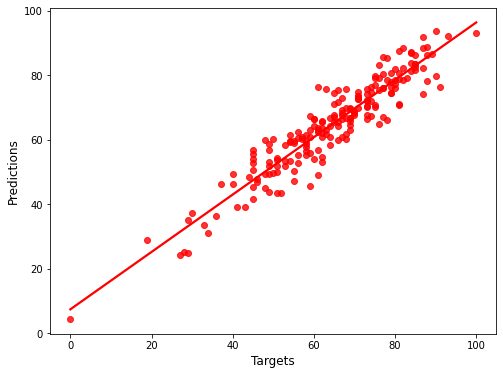

In [23]:
# scatter plot of the test set targets and predictions
plt.figure(figsize=(8, 6))
sns.regplot(x=ytest, y=yhat_test, ci=None, color="red")
plt.xlabel("Targets", fontsize=12)
plt.ylabel("Predictions", fontsize=12);

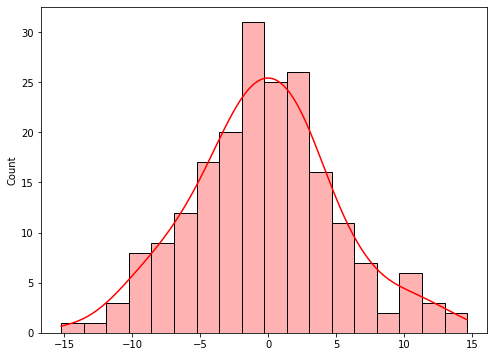

In [24]:
# distribution of residuals
n_bins = int(np.floor((1 + (3.322 * np.log(ytest.shape[0])))))
plt.figure(figsize=(8, 6))
sns.histplot(ytest-yhat_test, bins=n_bins, color="red", alpha=0.3, kde=True);

In [25]:
# output the test set adjusted R²
adj_r2 = adj_rsquared(Xtest, ytest, yhat_test)
print(f"Test set adjusted R²: {adj_r2:.2f}")

Test set adjusted R²: 0.87
